In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, Math
from scipy.optimize import curve_fit
from scipy.constants import epsilon_0
from sklearn.metrics import r2_score
import seaborn
seaborn.set()

def linear(x, a, b):
    return a*x + b

# Importando os dados

In [2]:
dados = pd.read_excel('campo-elétrico.xlsx')
dados

,E,ddp,z,v,tipo
0,1.659,10.1,0.1,ddp,disco
1,3.010,20.1,0.1,ddp,disco
2,4.600,30.0,0.1,ddp,disco
3,6.170,40.0,0.1,ddp,disco
4,7.710,50.1,0.1,ddp,disco
...,...,...,...,...,...
168,4.440,500.0,12.0,z,esfera
169,4.230,500.0,12.5,z,esfera
170,4.060,500.0,13.0,z,esfera
171,3.900,500.0,13.5,z,esfera


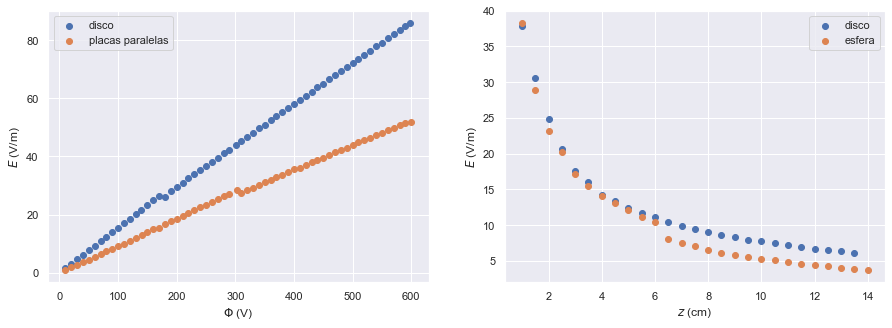

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
axis = {'ddp':ax1, 'z':ax2}

for (tipo, v), group in dados.groupby(['tipo', 'v']):
    axis[v].scatter(group[v], group.E, label=tipo)
    
ax1.set_xlabel(r'$\Phi$ (V)')
ax1.set_ylabel(r'$E$ (V/m)')
ax1.legend()

ax2.set_xlabel(r'$z$ (cm)')
ax2.set_ylabel(r'$E$ (V/m)')
ax2.legend()

plt.show()

# Análise da intensidade do campo em função da diferença de potencial ($E \times \Phi$)

Foram coletados dados sobre a intensidade do campo elétrico em função da diferença de potencial aplicada a condutores de diferentes geometrias. Primeiramente, o sensor foi posicionado de forma concêntrica a um disco conectado à uma fonte de tensão variável. Após isso, o sensor foi posicionado, também de forma concêntrica, entre duas placas condutoras com apenas uma delas (a que se opunha à interface do sensor) conectada à fonte de tensão. 

Em ambos os casos, o sensor foi posicionado de forma que efeitos de borda possam ser desprezados, fazendo com que a intensidade do campo $E$ possa ser descrita pela lei de gauss na forma
$$E = \dfrac{\sigma}{2\epsilon_0}$$
onde $\sigma$ é a densidade superficial de carga nos objetos.

In [130]:
ddp_dados = dados.loc[dados.v == 'ddp'].groupby('tipo')

## Verificação da mudança de escala do sensor

A escala do sensor utilizado nos experimentos precisou ser alterada em alguns pontos, fazendo com que a precisão dos dados se altere e gere um padrão de "degraus". Dessa forma, estes pontos podem ser detectados e as medidas podem ser divididas e analidadas separadamente.

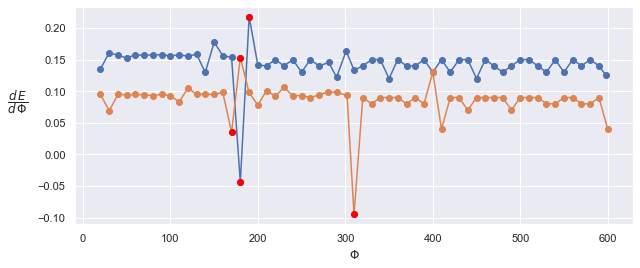

In [131]:
plt.figure(figsize=(10, 4))

split_slices = {}
for tipo, group in ddp_dados:
    dydx = group.E.diff()/group.ddp.diff()
    loc = (dydx - dydx.mean()).abs() > 0.05
    
    t = np.arange(len(group))
    split_slices[tipo] = [0] + list(t[loc]) + [t[-1]]
    
    x = group.ddp
    plt.plot(x, dydx, 'o-')
    plt.plot(x.loc[loc], dydx.loc[loc], 'o', c='red')
    
plt.ylabel(r'$\dfrac{d\,E}{d\,\Phi}$', rotation=0, labelpad=20)
plt.xlabel(r'$\Phi$')
plt.show()

In [132]:
split_slices

{'disco': [0, 17, 18, 59], 'placas paralelas': [0, 16, 17, 30, 59]}

## Ajustes de curva

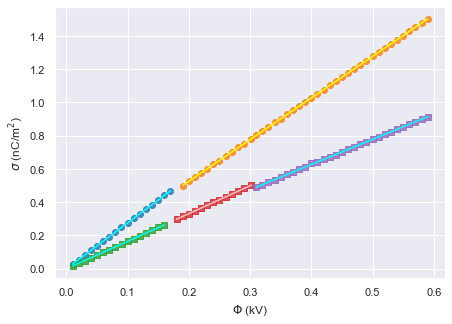

In [137]:
plt.figure(figsize=(7, 5))

color = iter(zip(mcolors.TABLEAU_COLORS.keys(), 
                 ('cyan', 'yellow', 'cyan', 'pink', 'cyan')))

resultados_params = ('a', 'b', 'std_a', 'std_b', 'r2')
resultados_dict = {
    'disco':[],
    'placas paralelas':[]
}

for (tipo, group) in ddp_dados:
    for i, j in zip(split_slices[tipo][:-1], split_slices[tipo][1:]):
        if j - i > 1:
            phi, E = group[['ddp', 'E']].values[i:j].T
            x, y = phi*1e-3 ,2*E*epsilon_0*1e9
            sc, pc = next(color)
            plt.scatter(x, y, c=sc, marker='o' if tipo == 'disco' else 's', alpha=0.8)
            
            (a, b), pcov = curve_fit(linear, x, y)
            std_a, std_b = np.sqrt(np.diag(pcov))
            resultados_dict[tipo].append((a, b, std_a, std_b, r2_score(y, linear(x, a, b))))
            
            X = np.linspace(x.min(), x.max(), 15)
            plt.plot(X, linear(X, a, b), c=pc)
    
plt.xlabel(r'$\Phi$ (kV)')
plt.ylabel(r'$\sigma$ (nC/m$^2$)')
#plt.legend()

plt.show()

## Resultados

### Resultados gerais

In [138]:
resultados = pd.DataFrame({
    (outerkey, innerkey): np.concatenate((values, [np.nan]*(3 - len(values))))
    for outerkey, arr in resultados_dict.items() 
    for innerkey, values in zip(resultados_params, np.transpose(arr))
})
resultados.T

0         1         2
disco            a      2.757850  2.505528       NaN
                 b     -0.000822  0.024794       NaN
                 std_a  0.006153  0.001860       NaN
                 std_b  0.000631  0.000758       NaN
                 r2     0.999925  0.999979       NaN
placas paralelas a      1.650631  1.679037  1.514110
                 b     -0.001248 -0.005116  0.020879
                 std_a  0.007784  0.006678  0.003748
                 std_b  0.000753  0.001623  0.001715
                 r2     0.999689  0.999826  0.999835

In [139]:
resultados.describe().T

count      mean       std       min       25%  \
disco            a        2.0  2.631689  0.178419  2.505528  2.568608   
                 b        2.0  0.011986  0.018113 -0.000822  0.005582   
                 std_a    2.0  0.004007  0.003036  0.001860  0.002933   
                 std_b    2.0  0.000694  0.000090  0.000631  0.000663   
                 r2       2.0  0.999952  0.000038  0.999925  0.999939   
placas paralelas a        3.0  1.614592  0.088172  1.514110  1.582370   
                 b        3.0  0.004838  0.014026 -0.005116 -0.003182   
                 std_a    3.0  0.006070  0.002086  0.003748  0.005213   
                 std_b    3.0  0.001364  0.000531  0.000753  0.001188   
                 r2       3.0  0.999783  0.000082  0.999689  0.999757   

                             50%       75%       max  
disco            a      2.631689  2.694769  2.757850  
                 b      0.011986  0.018390  0.024794  
                 std_a  0.004007  0.005080  0.006153  
                 std_b  0.000694  0.000726  0.000758  
                 r2     0.999952  0.999965  0.999979  
placas paralelas a      1.650631  1.664834  1.679037  
                 b     -0.001248  0.009815  0.020879  
                 std_a  0.006678  0.007231  0.007784  
                 std_b  0.001623  0.001669  0.001715  
                 r2     0.999826  0.999830  0.999835

### Estimativa para os coeficientes de capacitância

Obtendo um valor para o coeficiente angular $a$, para cada ajuste de curva $i$:
$$a = \overline{a_{R^2}} \pm \Delta a$$
onde $\overline{a_{R^2}}$ é a média dos valores de $a_i$ ponderada pelos respectivos coeficientes de derminação $R_i^2$, e $\Delta a$ o desvio padrão das medidas.


In [142]:
ang_coefs = []
for nome in ('disco', 'placas paralelas'):
    tipo = resultados[nome].dropna()
    a = np.average(tipo.a, weights=tipo.r2)
    da = tipo.a.std()
    ang_coefs.append((a, da))
    display(Math(r'{}: {} \pm {}'.format(
        nome.replace(' ', '\,'),
        np.round(a, 3),
        np.round(da, 3)
    )))

<IPython.core.display.Math object>

<IPython.core.display.Math object>